# ADNI Left Hippocampus split creation

This notebook reads subject IDs from the ADNI metadata CSV and splits left hippocampus OBJ scans into train/val/test by subject, so each subject's scans stay in a single split.

Output directory (relative to the notebook's working directory):
`../examples/splits/splits_left_hippocampus_ADNI`


In [32]:
from pathlib import Path
import csv
import json
import random
import re

metadata_csv = Path('[path to metadata file]')
obj_dir = Path('[path to mesh folder: minimal_smooth_final_obj]')
output_dir = Path('../examples/splits/splits_right_hippocampus_ADNI_smooth')

train_ratio = 0.85
test_ratio = 0.10
val_ratio = 0.05
random_seed = 42

assert abs(train_ratio + test_ratio + val_ratio - 1.0) < 1e-6
output_dir.mkdir(parents=True, exist_ok=True)



In [34]:
subject_ids = set()
with metadata_csv.open(newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        sid = row.get('subject_id')
        if sid:
            subject_ids.add(sid.strip())

print(f'Metadata subjects: {len(subject_ids)}')


Metadata subjects: 489


In [35]:
obj_files = sorted(p.name for p in obj_dir.glob('*.obj'))

subject_pattern = re.compile(r'ADNI_(\d+_S_\d+)_')
subject_to_files = {}
unmatched_files = []
unknown_subject_files = []

for fname in obj_files:
    match = subject_pattern.search(fname)
    if not match:
        unmatched_files.append(fname)
        continue
    sid = match.group(1)
    if sid not in subject_ids:
        unknown_subject_files.append(fname)
        continue
    subject_to_files.setdefault(sid, []).append(fname)

subjects = sorted(subject_to_files.keys())
print(f'OBJ files: {len(obj_files)}')
print(f'Subjects with OBJ files: {len(subjects)}')
print(f'Unmatched files (pattern): {len(unmatched_files)}')
print(f'Files with subject not in metadata: {len(unknown_subject_files)}')


OBJ files: 1633
Subjects with OBJ files: 489
Unmatched files (pattern): 1
Files with subject not in metadata: 0


In [36]:
rng = random.Random(random_seed)
rng.shuffle(subjects)

num_subjects = len(subjects)
num_train = int(num_subjects * train_ratio)
num_test = int(num_subjects * test_ratio)
num_val = num_subjects - num_train - num_test

train_subjects = subjects[:num_train]
test_subjects = subjects[num_train:num_train + num_test]
val_subjects = subjects[num_train + num_test:]

def collect_files(subject_list):
    files = []
    for sid in subject_list:
        files.extend(subject_to_files[sid])
    return sorted(files)

train_files = collect_files(train_subjects)
test_files = collect_files(test_subjects)
val_files = collect_files(val_subjects)

train_path = output_dir / 'train_split_left_hippocampus_adni.json'
test_path = output_dir / 'test_split_left_hippocampus_adni.json'
val_path = output_dir / 'val_split_left_hippocampus_adni.json'

with train_path.open('w') as f:
    json.dump(train_files, f)
with test_path.open('w') as f:
    json.dump(test_files, f)
with val_path.open('w') as f:
    json.dump(val_files, f)

print('Wrote:', train_path, test_path, val_path)
print(f'Train subjects/files: {len(train_subjects)}/{len(train_files)}')
print(f'Test subjects/files: {len(test_subjects)}/{len(test_files)}')
print(f'Val subjects/files: {len(val_subjects)}/{len(val_files)}')
print(f'Subject ratios: train {len(train_subjects) / num_subjects:.2%}, '
      f'test {len(test_subjects) / num_subjects:.2%}, '
      f'val {len(val_subjects) / num_subjects:.2%}')


Wrote: ../examples/splits/splits_right_hippocampus_ADNI_smooth/train_split_left_hippocampus_adni.json ../examples/splits/splits_right_hippocampus_ADNI_smooth/test_split_left_hippocampus_adni.json ../examples/splits/splits_right_hippocampus_ADNI_smooth/val_split_left_hippocampus_adni.json
Train subjects/files: 415/1387
Test subjects/files: 48/156
Val subjects/files: 26/89
Subject ratios: train 84.87%, test 9.82%, val 5.32%


In [37]:
train_subjects_set = set(train_subjects)
test_subjects_set = set(test_subjects)
val_subjects_set = set(val_subjects)

assert train_subjects_set.isdisjoint(test_subjects_set)
assert train_subjects_set.isdisjoint(val_subjects_set)
assert test_subjects_set.isdisjoint(val_subjects_set)
assert train_subjects_set | test_subjects_set | val_subjects_set == set(subjects)

train_files_set = set(train_files)
test_files_set = set(test_files)
val_files_set = set(val_files)

assert train_files_set.isdisjoint(test_files_set)
assert train_files_set.isdisjoint(val_files_set)
assert test_files_set.isdisjoint(val_files_set)

all_split_files = train_files_set | test_files_set | val_files_set
all_subject_files = set()
for files in subject_to_files.values():
    all_subject_files.update(files)

assert all_split_files == all_subject_files

subject_to_split = {}
for sid in train_subjects:
    subject_to_split[sid] = 'train'
for sid in test_subjects:
    subject_to_split[sid] = 'test'
for sid in val_subjects:
    subject_to_split[sid] = 'val'

for sid, files in subject_to_files.items():
    split = subject_to_split[sid]
    if split == 'train':
        assert set(files).issubset(train_files_set)
    elif split == 'test':
        assert set(files).issubset(test_files_set)
    else:
        assert set(files).issubset(val_files_set)

print('Split checks passed.')


Split checks passed.


# ADNI left hippocampus split creation without MCI

This section creates a split that excludes any subjects with an MCI diagnosis, keeping only CN and AD.


In [38]:
subject_to_diagnoses = {}
with metadata_csv.open(newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        sid = row.get('subject_id')
        diag = row.get('diagnosis')
        if not sid or not diag:
            continue
        sid = sid.strip()
        diag = diag.strip()
        subject_to_diagnoses.setdefault(sid, set()).add(diag)

allowed_diagnoses = {'CN', 'AD'}
subjects_no_mci = [
    sid for sid in subjects
    if subject_to_diagnoses.get(sid) and subject_to_diagnoses[sid].issubset(allowed_diagnoses)
]
subjects_no_mci = sorted(subjects_no_mci)

print(f'Subjects CN/AD only: {len(subjects_no_mci)}')

rng_no_mci = random.Random(random_seed)
rng_no_mci.shuffle(subjects_no_mci)

num_subjects_no_mci = len(subjects_no_mci)
num_train_no_mci = int(num_subjects_no_mci * train_ratio)
num_test_no_mci = int(num_subjects_no_mci * test_ratio)
num_val_no_mci = num_subjects_no_mci - num_train_no_mci - num_test_no_mci

train_subjects_no_mci = subjects_no_mci[:num_train_no_mci]
test_subjects_no_mci = subjects_no_mci[num_train_no_mci:num_train_no_mci + num_test_no_mci]
val_subjects_no_mci = subjects_no_mci[num_train_no_mci + num_test_no_mci:]

train_files_no_mci = collect_files(train_subjects_no_mci)
test_files_no_mci = collect_files(test_subjects_no_mci)
val_files_no_mci = collect_files(val_subjects_no_mci)

train_path_no_mci = output_dir / 'train_split_left_hippocampus_adni_no_mci.json'
test_path_no_mci = output_dir / 'test_split_left_hippocampus_adni_no_mci.json'
val_path_no_mci = output_dir / 'val_split_left_hippocampus_adni_no_mci.json'

with train_path_no_mci.open('w') as f:
    json.dump(train_files_no_mci, f)
with test_path_no_mci.open('w') as f:
    json.dump(test_files_no_mci, f)
with val_path_no_mci.open('w') as f:
    json.dump(val_files_no_mci, f)

print('Wrote:', train_path_no_mci, test_path_no_mci, val_path_no_mci)
print(f'Train subjects/files: {len(train_subjects_no_mci)}/{len(train_files_no_mci)}')
print(f'Test subjects/files: {len(test_subjects_no_mci)}/{len(test_files_no_mci)}')
print(f'Val subjects/files: {len(val_subjects_no_mci)}/{len(val_files_no_mci)}')
print(f'Subject ratios: train {len(train_subjects_no_mci) / num_subjects_no_mci:.2%}, '
      f'test {len(test_subjects_no_mci) / num_subjects_no_mci:.2%}, '
      f'val {len(val_subjects_no_mci) / num_subjects_no_mci:.2%}')

train_subjects_no_mci_set = set(train_subjects_no_mci)
test_subjects_no_mci_set = set(test_subjects_no_mci)
val_subjects_no_mci_set = set(val_subjects_no_mci)

assert train_subjects_no_mci_set.isdisjoint(test_subjects_no_mci_set)
assert train_subjects_no_mci_set.isdisjoint(val_subjects_no_mci_set)
assert test_subjects_no_mci_set.isdisjoint(val_subjects_no_mci_set)
assert train_subjects_no_mci_set | test_subjects_no_mci_set | val_subjects_no_mci_set == set(subjects_no_mci)

train_files_no_mci_set = set(train_files_no_mci)
test_files_no_mci_set = set(test_files_no_mci)
val_files_no_mci_set = set(val_files_no_mci)

assert train_files_no_mci_set.isdisjoint(test_files_no_mci_set)
assert train_files_no_mci_set.isdisjoint(val_files_no_mci_set)
assert test_files_no_mci_set.isdisjoint(val_files_no_mci_set)

all_split_files_no_mci = train_files_no_mci_set | test_files_no_mci_set | val_files_no_mci_set
all_subject_files_no_mci = set()
for sid in subjects_no_mci:
    all_subject_files_no_mci.update(subject_to_files[sid])

assert all_split_files_no_mci == all_subject_files_no_mci

subject_to_split_no_mci = {}
for sid in train_subjects_no_mci:
    subject_to_split_no_mci[sid] = 'train'
for sid in test_subjects_no_mci:
    subject_to_split_no_mci[sid] = 'test'
for sid in val_subjects_no_mci:
    subject_to_split_no_mci[sid] = 'val'

for sid, files in subject_to_files.items():
    if sid not in subject_to_split_no_mci:
        continue
    split = subject_to_split_no_mci[sid]
    if split == 'train':
        assert set(files).issubset(train_files_no_mci_set)
    elif split == 'test':
        assert set(files).issubset(test_files_no_mci_set)
    else:
        assert set(files).issubset(val_files_no_mci_set)

for sid in subjects_no_mci:
    assert subject_to_diagnoses[sid].issubset(allowed_diagnoses)

print('No-MCI split checks passed.')


Subjects CN/AD only: 247
Wrote: ../examples/splits/splits_right_hippocampus_ADNI_smooth/train_split_left_hippocampus_adni_no_mci.json ../examples/splits/splits_right_hippocampus_ADNI_smooth/test_split_left_hippocampus_adni_no_mci.json ../examples/splits/splits_right_hippocampus_ADNI_smooth/val_split_left_hippocampus_adni_no_mci.json
Train subjects/files: 209/696
Test subjects/files: 24/77
Val subjects/files: 14/46
Subject ratios: train 84.62%, test 9.72%, val 5.67%
No-MCI split checks passed.


OBJ files: 1633
Subjects with OBJ files: 489
Unmatched files (pattern): 1
Files with subject not in metadata: 0
Subjects CN/AD only (with age+gender): 247
Split strategy: age_bin=20 (temp strat: diag+gender)
Wrote: ../examples/splits/splits_left_hippocampus_ADNI_No_MCI_stratified/train_split_left_hippocampus_adni_no_mci.json ../examples/splits/splits_left_hippocampus_ADNI_No_MCI_stratified/test_split_left_hippocampus_adni_no_mci.json ../examples/splits/splits_left_hippocampus_ADNI_No_MCI_stratified/val_split_left_hippocampus_adni_no_mci.json
Train subjects/files: 197/659
Test subjects/files: 25/81
Val subjects/files: 25/79
Subject ratios: train 79.76%, test 10.12%, val 10.12%
No-MCI stratified split checks passed.

Train split: 197 subjects
  Diagnosis %: {'CN': 0.5888324873096447, 'AD': 0.41116751269035534}
  Gender %   : {'F': 0.48223350253807107, 'M': 0.5177664974619289}
  Age mean±std: 76.66±5.89

Test split: 25 subjects
  Diagnosis %: {'CN': 0.56, 'AD': 0.44}
  Gender %   : {'F': 

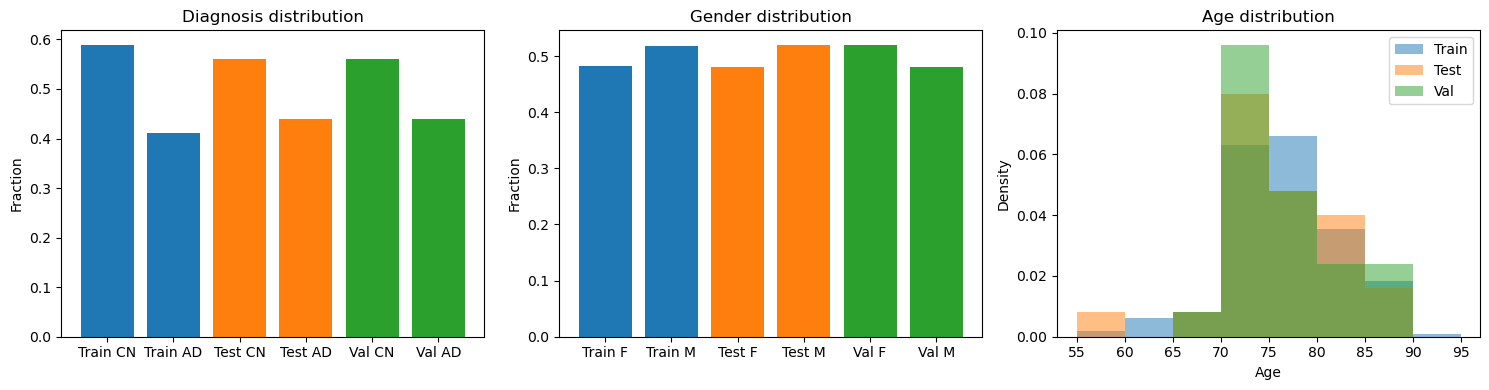

In [7]:
# Standalone: stratified CN/AD (no MCI) split for LEFT hippocampus (80/10/10)
from pathlib import Path
import csv
import json
import random
import re
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

metadata_csv = Path('[path to metadata file]')
obj_dir = Path('[path to mesh folder: minimal_scaled_obj_files]')
output_dir = Path('../examples/splits/splits_left_hippocampus_ADNI_No_MCI_stratified')
output_dir.mkdir(parents=True, exist_ok=True)

train_ratio, test_ratio, val_ratio = 0.80, 0.10, 0.10
random_seed = 40
assert abs(train_ratio + test_ratio + val_ratio - 1.0) < 1e-6

# ---- Load metadata per subject ----
subject_meta = defaultdict(lambda: {'diag': [], 'gender': [], 'age': []})
with metadata_csv.open(newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        sid = (row.get('subject_id') or '').strip()
        if not sid:
            continue
        diag = (row.get('diagnosis') or '').strip()
        gender = (row.get('gender') or '').strip()
        age = (row.get('age') or '').strip()
        if diag:
            subject_meta[sid]['diag'].append(diag)
        if gender:
            subject_meta[sid]['gender'].append(gender)
        if age:
            try:
                subject_meta[sid]['age'].append(float(age))
            except ValueError:
                pass

# ---- Map OBJ files to subjects ----
obj_files = sorted(p.name for p in obj_dir.glob('*.obj'))
subject_pattern = re.compile(r'ADNI_(\d+_S_\d+)_')
subject_to_files = defaultdict(list)
unmatched_files = []
unknown_subject_files = []

for fname in obj_files:
    match = subject_pattern.search(fname)
    if not match:
        unmatched_files.append(fname)
        continue
    sid = match.group(1)
    if sid not in subject_meta:
        unknown_subject_files.append(fname)
        continue
    subject_to_files[sid].append(fname)

subjects_with_files = sorted(subject_to_files.keys())
print(f'OBJ files: {len(obj_files)}')
print(f'Subjects with OBJ files: {len(subjects_with_files)}')
print(f'Unmatched files (pattern): {len(unmatched_files)}')
print(f'Files with subject not in metadata: {len(unknown_subject_files)}')

# ---- Filter subjects: CN/AD only (no MCI) ----
allowed = {'CN', 'AD'}
subjects = []
diag_label = {}
gender_label = {}
age_mean = {}

for sid in subjects_with_files:
    diags = set(subject_meta[sid]['diag'])
    if not diags or not diags.issubset(allowed):
        continue
    ages = subject_meta[sid]['age']
    genders = subject_meta[sid]['gender']
    if not ages or not genders:
        continue
    # Subject-level diagnosis: AD if any AD, else CN
    diag_label[sid] = 'AD' if 'AD' in diags else 'CN'
    # Subject-level gender: most common value
    g = Counter(genders).most_common(1)[0][0]
    gender_label[sid] = g
    age_mean[sid] = float(np.mean(ages))
    subjects.append(sid)

subjects = sorted(subjects)
print(f'Subjects CN/AD only (with age+gender): {len(subjects)}')

# ---- Stratified split by (diag, gender, age_bin) ----
def build_labels(bin_size):
    labels = []
    age_bins = {}
    for sid in subjects:
        a = age_mean[sid]
        b0 = int((a // bin_size) * bin_size)
        b1 = b0 + bin_size - 1
        age_bins[sid] = f'{b0}-{b1}'
        labels.append(f"{diag_label[sid]}|{gender_label[sid]}|{age_bins[sid]}")
    return np.array(labels), age_bins

def split_with_labels(labels, note):
    subj_arr = np.array(subjects)
    train_subj, temp_subj, train_lbl, temp_lbl = train_test_split(
        subj_arr, labels, test_size=(1 - train_ratio),
        stratify=labels, random_state=random_seed
    )
    # split temp into test/val
    test_size_rel = val_ratio / (test_ratio + val_ratio)  # fraction of temp assigned to val
    try:
        test_subj, val_subj = train_test_split(
            temp_subj, test_size=test_size_rel,
            stratify=temp_lbl, random_state=random_seed
        )
        return train_subj, test_subj, val_subj, note
    except ValueError:
        # fallback: stratify temp by diag+gender only
        temp_lbl2 = np.array([f"{diag_label[s]}|{gender_label[s]}" for s in temp_subj])
        test_subj, val_subj = train_test_split(
            temp_subj, test_size=test_size_rel,
            stratify=temp_lbl2, random_state=random_seed
        )
        return train_subj, test_subj, val_subj, note + ' (temp strat: diag+gender)'

bin_sizes = [5, 10, 15, 20]
split_note = None
for b in bin_sizes:
    labels, age_bins = build_labels(b)
    try:
        train_subj, test_subj, val_subj, split_note = split_with_labels(labels, f'age_bin={b}')
        break
    except ValueError as e:
        continue

if split_note is None:
    raise RuntimeError('Unable to stratify with age bins; try larger bins or inspect data.')

print('Split strategy:', split_note)

def collect_files(subj_list):
    files = []
    for sid in subj_list:
        files.extend(subject_to_files[sid])
    return sorted(files)

train_files = collect_files(train_subj)
test_files = collect_files(test_subj)
val_files = collect_files(val_subj)

train_path = output_dir / 'train_split_left_hippocampus_adni_no_mci.json'
test_path = output_dir / 'test_split_left_hippocampus_adni_no_mci.json'
val_path = output_dir / 'val_split_left_hippocampus_adni_no_mci.json'

with train_path.open('w') as f:
    json.dump(train_files, f)
with test_path.open('w') as f:
    json.dump(test_files, f)
with val_path.open('w') as f:
    json.dump(val_files, f)

print('Wrote:', train_path, test_path, val_path)
print(f'Train subjects/files: {len(train_subj)}/{len(train_files)}')
print(f'Test subjects/files: {len(test_subj)}/{len(test_files)}')
print(f'Val subjects/files: {len(val_subj)}/{len(val_files)}')
print(f'Subject ratios: train {len(train_subj)/len(subjects):.2%}, '
      f'test {len(test_subj)/len(subjects):.2%}, val {len(val_subj)/len(subjects):.2%}')

# ---- Sanity checks ----
train_set = set(train_subj); test_set = set(test_subj); val_set = set(val_subj)
assert train_set.isdisjoint(test_set)
assert train_set.isdisjoint(val_set)
assert test_set.isdisjoint(val_set)
assert train_set | test_set | val_set == set(subjects)

train_files_set = set(train_files)
test_files_set = set(test_files)
val_files_set = set(val_files)
assert train_files_set.isdisjoint(test_files_set)
assert train_files_set.isdisjoint(val_files_set)
assert test_files_set.isdisjoint(val_files_set)

all_split_files = train_files_set | test_files_set | val_files_set
all_subject_files = set()
for sid in subjects:
    all_subject_files.update(subject_to_files[sid])
assert all_split_files == all_subject_files

print('No-MCI stratified split checks passed.')

# ---- Distribution checks ----
def summarize_split(name, subj_list):
    diag = [diag_label[s] for s in subj_list]
    gender = [gender_label[s] for s in subj_list]
    ages = [age_mean[s] for s in subj_list]
    diag_counts = Counter(diag)
    gender_counts = Counter(gender)
    diag_pct = {k: diag_counts.get(k, 0)/len(subj_list) for k in diag_order}
    gender_pct = {k: gender_counts.get(k, 0)/len(subj_list) for k in gender_order}
    print(f'\n{name} split: {len(subj_list)} subjects')
    print('  Diagnosis %:', diag_pct)
    print('  Gender %   :', gender_pct)
    print('  Age mean±std:', f"{np.mean(ages):.2f}±{np.std(ages):.2f}")
    return diag, gender, ages

train_diag, train_gender, train_ages = summarize_split('Train', train_subj)
test_diag, test_gender, test_ages = summarize_split('Test', test_subj)
val_diag, val_gender, val_ages = summarize_split('Val', val_subj)

# Plot distributions
diag_order = ['CN', 'AD']
gender_order = ['F', 'M']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Diagnosis
for split_name, diag in [('Train', train_diag), ('Test', test_diag), ('Val', val_diag)]:
    counts = Counter(diag)
    axes[0].bar([f'{split_name} {k}' for k in diag_order],
                [counts.get(k, 0)/len(diag) for k in diag_order])
axes[0].set_title('Diagnosis distribution')
axes[0].set_ylabel('Fraction')

# Gender
for split_name, gender in [('Train', train_gender), ('Test', test_gender), ('Val', val_gender)]:
    counts = Counter(gender)
    axes[1].bar([f'{split_name} {k}' for k in gender_order],
                [counts.get(k, 0)/len(gender) for k in gender_order])
axes[1].set_title('Gender distribution')
axes[1].set_ylabel('Fraction')

# Age histogram (same bins)
bins = np.arange(min(age_mean.values())//5*5, max(age_mean.values())//5*5 + 10, 5)
axes[2].hist(train_ages, bins=bins, alpha=0.5, label='Train', density=True)
axes[2].hist(test_ages, bins=bins, alpha=0.5, label='Test', density=True)
axes[2].hist(val_ages, bins=bins, alpha=0.5, label='Val', density=True)
axes[2].set_title('Age distribution')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout()
plt.show()



OBJ files: 1633
Subjects with OBJ files: 489
Unmatched files (pattern): 1
Files with subject not in metadata: 0
Subjects with labels (all diagnoses): 489
Split strategy: age_bin=20 (temp strat: diag+gender)
Wrote: ../examples/splits/splits_left_hippocampus_ADNI_stratified/train_split_left_hippocampus_adni.json ../examples/splits/splits_left_hippocampus_ADNI_stratified/test_split_left_hippocampus_adni.json ../examples/splits/splits_left_hippocampus_ADNI_stratified/val_split_left_hippocampus_adni.json
Train subjects/files: 391/1303
Test subjects/files: 49/162
Val subjects/files: 49/167
Subject ratios: train 79.96%, test 10.02%, val 10.02%
Stratified split checks passed.

Train split: 391 subjects
  Diagnosis %: {'CN': 0.2966751918158568, 'MCI': 0.4961636828644501, 'AD': 0.2071611253196931}
  Gender %   : {'F': 0.4296675191815857, 'M': 0.5703324808184144}
  Age mean±std: 76.03±6.61

Test split: 49 subjects
  Diagnosis %: {'CN': 0.2857142857142857, 'MCI': 0.4897959183673469, 'AD': 0.224489

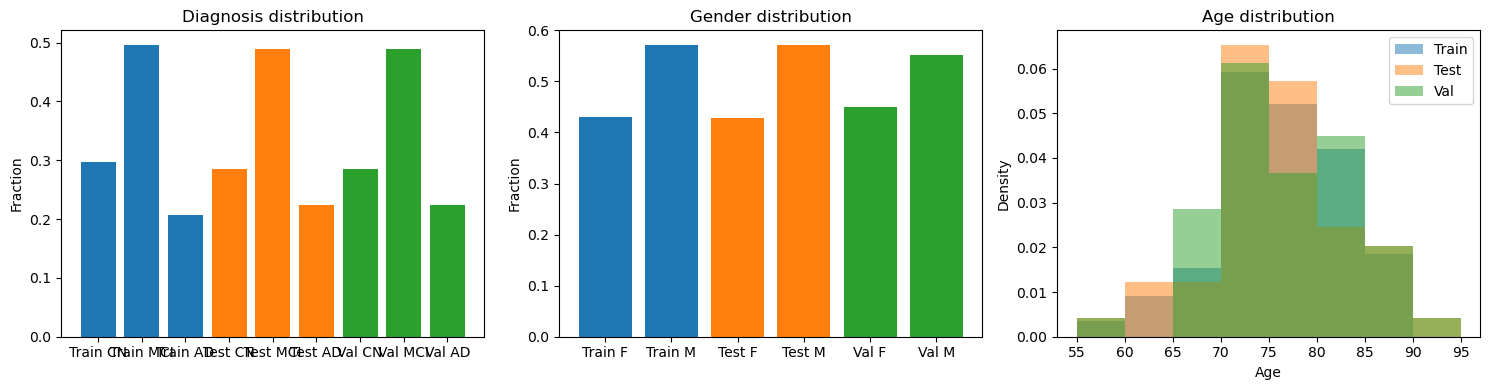

In [8]:
# Standalone: stratified split for LEFT hippocampus (ALL diagnoses, incl. MCI)
from pathlib import Path
import csv
import json
import re
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

metadata_csv = Path('[path to metadata file]')
obj_dir = Path('[path to mesh folder: minimal_scaled_obj_files]')
output_dir = Path('../examples/splits/splits_left_hippocampus_ADNI_stratified')
output_dir.mkdir(parents=True, exist_ok=True)

train_ratio, test_ratio, val_ratio = 0.80, 0.10, 0.10
random_seed = 42
assert abs(train_ratio + test_ratio + val_ratio - 1.0) < 1e-6

# ---- Load metadata per subject ----
subject_meta = defaultdict(lambda: {'diag': [], 'gender': [], 'age': []})
with metadata_csv.open(newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        sid = (row.get('subject_id') or '').strip()
        if not sid:
            continue
        diag = (row.get('diagnosis') or '').strip()
        gender = (row.get('gender') or '').strip()
        age = (row.get('age') or '').strip()
        if diag:
            subject_meta[sid]['diag'].append(diag)
        if gender:
            subject_meta[sid]['gender'].append(gender)
        if age:
            try:
                subject_meta[sid]['age'].append(float(age))
            except ValueError:
                pass

# ---- Map OBJ files to subjects ----
obj_files = sorted(p.name for p in obj_dir.glob('*.obj'))
subject_pattern = re.compile(r'ADNI_(\d+_S_\d+)_')
subject_to_files = defaultdict(list)
unmatched_files = []
unknown_subject_files = []

for fname in obj_files:
    match = subject_pattern.search(fname)
    if not match:
        unmatched_files.append(fname)
        continue
    sid = match.group(1)
    if sid not in subject_meta:
        unknown_subject_files.append(fname)
        continue
    subject_to_files[sid].append(fname)

subjects_with_files = sorted(subject_to_files.keys())
print(f'OBJ files: {len(obj_files)}')
print(f'Subjects with OBJ files: {len(subjects_with_files)}')
print(f'Unmatched files (pattern): {len(unmatched_files)}')
print(f'Files with subject not in metadata: {len(unknown_subject_files)}')

# ---- Build subject-level labels (diag/gender/age) ----
subjects = []
diag_label = {}
gender_label = {}
age_mean = {}

for sid in subjects_with_files:
    diags = [d for d in subject_meta[sid]['diag'] if d]
    ages = subject_meta[sid]['age']
    genders = subject_meta[sid]['gender']
    if not diags or not ages or not genders:
        continue
    # Subject-level diagnosis: majority vote, fallback to most recent entry
    diag = Counter(diags).most_common(1)[0][0]
    diag_label[sid] = diag
    # Subject-level gender: most common value
    gender_label[sid] = Counter(genders).most_common(1)[0][0]
    age_mean[sid] = float(np.mean(ages))
    subjects.append(sid)

subjects = sorted(subjects)
print(f'Subjects with labels (all diagnoses): {len(subjects)}')

# ---- Stratified split by (diag, gender, age_bin) ----
def build_labels(bin_size):
    labels = []
    for sid in subjects:
        a = age_mean[sid]
        b0 = int((a // bin_size) * bin_size)
        b1 = b0 + bin_size - 1
        age_bin = f'{b0}-{b1}'
        labels.append(f"{diag_label[sid]}|{gender_label[sid]}|{age_bin}")
    return np.array(labels)

def split_with_labels(labels, note):
    subj_arr = np.array(subjects)
    train_subj, temp_subj, train_lbl, temp_lbl = train_test_split(
        subj_arr, labels, test_size=(1 - train_ratio),
        stratify=labels, random_state=random_seed
    )
    test_size_rel = val_ratio / (test_ratio + val_ratio)
    try:
        test_subj, val_subj = train_test_split(
            temp_subj, test_size=test_size_rel,
            stratify=temp_lbl, random_state=random_seed
        )
        return train_subj, test_subj, val_subj, note
    except ValueError:
        # fallback: stratify temp by diag+gender only
        temp_lbl2 = np.array([f"{diag_label[s]}|{gender_label[s]}" for s in temp_subj])
        test_subj, val_subj = train_test_split(
            temp_subj, test_size=test_size_rel,
            stratify=temp_lbl2, random_state=random_seed
        )
        return train_subj, test_subj, val_subj, note + ' (temp strat: diag+gender)'

bin_sizes = [5, 10, 15, 20]
split_note = None
for b in bin_sizes:
    labels = build_labels(b)
    try:
        train_subj, test_subj, val_subj, split_note = split_with_labels(labels, f'age_bin={b}')
        break
    except ValueError:
        continue

if split_note is None:
    raise RuntimeError('Unable to stratify with age bins; try larger bins or inspect data.')

print('Split strategy:', split_note)

def collect_files(subj_list):
    files = []
    for sid in subj_list:
        files.extend(subject_to_files[sid])
    return sorted(files)

train_files = collect_files(train_subj)
test_files = collect_files(test_subj)
val_files = collect_files(val_subj)

train_path = output_dir / 'train_split_left_hippocampus_adni.json'
test_path = output_dir / 'test_split_left_hippocampus_adni.json'
val_path = output_dir / 'val_split_left_hippocampus_adni.json'

with train_path.open('w') as f:
    json.dump(train_files, f)
with test_path.open('w') as f:
    json.dump(test_files, f)
with val_path.open('w') as f:
    json.dump(val_files, f)

print('Wrote:', train_path, test_path, val_path)
print(f'Train subjects/files: {len(train_subj)}/{len(train_files)}')
print(f'Test subjects/files: {len(test_subj)}/{len(test_files)}')
print(f'Val subjects/files: {len(val_subj)}/{len(val_files)}')
print(f'Subject ratios: train {len(train_subj)/len(subjects):.2%}, '
      f'test {len(test_subj)/len(subjects):.2%}, val {len(val_subj)/len(subjects):.2%}')

# ---- Sanity checks ----
train_set = set(train_subj); test_set = set(test_subj); val_set = set(val_subj)
assert train_set.isdisjoint(test_set)
assert train_set.isdisjoint(val_set)
assert test_set.isdisjoint(val_set)
assert train_set | test_set | val_set == set(subjects)

train_files_set = set(train_files)
test_files_set = set(test_files)
val_files_set = set(val_files)
assert train_files_set.isdisjoint(test_files_set)
assert train_files_set.isdisjoint(val_files_set)
assert test_files_set.isdisjoint(val_files_set)

all_split_files = train_files_set | test_files_set | val_files_set
all_subject_files = set()
for sid in subjects:
    all_subject_files.update(subject_to_files[sid])
assert all_split_files == all_subject_files

print('Stratified split checks passed.')

# ---- Distribution checks ----
diag_order = ['CN', 'MCI', 'AD']
gender_order = ['F', 'M']
def summarize_split(name, subj_list):
    diag = [diag_label[s] for s in subj_list]
    gender = [gender_label[s] for s in subj_list]
    ages = [age_mean[s] for s in subj_list]
    diag_counts = Counter(diag)
    gender_counts = Counter(gender)
    diag_pct = {k: diag_counts.get(k, 0)/len(subj_list) for k in diag_order}
    gender_pct = {k: gender_counts.get(k, 0)/len(subj_list) for k in gender_order}
    print(f'\n{name} split: {len(subj_list)} subjects')
    print('  Diagnosis %:', diag_pct)
    print('  Gender %   :', gender_pct)
    print('  Age mean±std:', f"{np.mean(ages):.2f}±{np.std(ages):.2f}")
    return diag, gender, ages

train_diag, train_gender, train_ages = summarize_split('Train', train_subj)
test_diag, test_gender, test_ages = summarize_split('Test', test_subj)
val_diag, val_gender, val_ages = summarize_split('Val', val_subj)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Diagnosis
for split_name, diag in [('Train', train_diag), ('Test', test_diag), ('Val', val_diag)]:
    counts = Counter(diag)
    axes[0].bar([f'{split_name} {k}' for k in diag_order],
                [counts.get(k, 0)/len(diag) for k in diag_order])
axes[0].set_title('Diagnosis distribution')
axes[0].set_ylabel('Fraction')

# Gender
for split_name, gender in [('Train', train_gender), ('Test', test_gender), ('Val', val_gender)]:
    counts = Counter(gender)
    axes[1].bar([f'{split_name} {k}' for k in gender_order],
                [counts.get(k, 0)/len(gender) for k in gender_order])
axes[1].set_title('Gender distribution')
axes[1].set_ylabel('Fraction')

# Age histogram (same bins)
bins = np.arange(min(age_mean.values())//5*5, max(age_mean.values())//5*5 + 10, 5)
axes[2].hist(train_ages, bins=bins, alpha=0.5, label='Train', density=True)
axes[2].hist(test_ages, bins=bins, alpha=0.5, label='Test', density=True)
axes[2].hist(val_ages, bins=bins, alpha=0.5, label='Val', density=True)
axes[2].set_title('Age distribution')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout()
plt.show()

